**COMP-5011-FDE Machine Learning & Neural Network**

**Project** 

**Name**: Khushal Paresh Thaker

**Student ID**: 1106937


---



**Task**: Object-centric Small Image recognition task with medium datasets

**Dataset**: CIFAR10, **CIFAR100** 


**Contents**


1.   Library Import
2.   BiT model Load
3.   Dataset (Cifar100) Loading and necessary preprocessing
4.   Cuda C based ELM Code
5.   Training the Model
6.   Testing the Model



##1. Library Import

In [1]:
# Importing necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np

In [2]:
# setting the constant values used in the rest of the code.
NUM_CLASSES = 100
BATCH_SIZE = 1000
DATASET_NUM_TRAIN_EXAMPLES = 50000
RESIZE_TO = 128

## 2. BiT Model Load

In [3]:
# Using the state-of-the-art model - Big Transfer (BiT) for acheiving high accuracy.
class FeatureNet(tf.keras.Model):
  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros', use_bias=False)
    self.bit_model = module
    self.bit_model.trainable = False #freeze the backbone network
    
  def call(self, images):
    bit_embedding = self.bit_model(images)
    return bit_embedding, self.head(bit_embedding)

# We use the state-of-the-art model for transfer learning from Google: Big Transfer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=False)
model = FeatureNet(num_classes=NUM_CLASSES, module=module)

## 3. Dataset (Cifar100) loading and necessary preprocessing

In [4]:
# loading the train and test set from cifar100 dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# printing information about the cifar100 dataset
ds_info

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incomplete7YDEC5/cifar100-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incomplete7YDEC5/cifar100-test.tfrecord


Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {

,image,label
0,,23 (cloud)
1,,66 (raccoon)
2,,39 (keyboard)
3,,40 (lamp)
4,,7 (beetle)

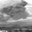
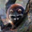
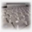
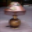
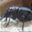

In [5]:
# using dataframe functionality to understand the dataset
tfds.as_dataframe(ds_train.take(5), ds_info)

Processing for the train and test sets. The preprocessing phase includes dividing the pixel values by 255 to make them in the [0,1] range. Besides images are resized from 32x32 to 128x128 which helped achieve higher accuracy.

In [6]:
def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def trainSet_preprocess(features, label):
  features = tf.image.random_flip_left_right(features)
  features = tf.image.resize(features, [RESIZE_TO, RESIZE_TO])
  features = tf.cast(features, tf.float32) / 255.0
  return features, label

def testSet_preprocess(features, label):
  features = tf.image.resize(features, [RESIZE_TO, RESIZE_TO])
  features = tf.cast(features, tf.float32) / 255.0
  return features, label

trainSet_processFlow = (ds_train
                  .shuffle(DATASET_NUM_TRAIN_EXAMPLES)
                  .map(trainSet_preprocess, num_parallel_calls=4)
                  .batch(BATCH_SIZE)
                  .prefetch(2))

testSet_processFlow = (ds_test.map(testSet_preprocess, num_parallel_calls=1)
                  .batch(BATCH_SIZE)
                  .prefetch(2))

## 4. Cuda C based ELM code

We now extract all the training data features and labels and store them into files named features.txt and labels.txt, respectively. These two files will be opened by the CUDA-based ELM, then it will write the output into another file called weights.txt which we will read later in this notebook to perform the evaluation.

In [7]:
!rm -f features.txt labels.txt
f_f = open('features.txt', 'a')
l_f = open('labels.txt', 'a')
    
for step, (x_batch_train, y_batch_train) in enumerate(trainSet_processFlow):
    # extracting features
    H, _ = model(x_batch_train, training=False)
    argstr_feats = ''
    argstr_labels = ''
    t = tf.one_hot(y_batch_train, NUM_CLASSES)
    # Write the features into file
    for row in np.array(H):
        for element in row:
            argstr_feats += (format(element, '.12f') + " ")
        argstr_feats += '\n'
    f_f.write(argstr_feats)
    # Write the labels into file
    for row in np.array(t):
        for element in row:
            argstr_labels += (str(element) + " ")
        argstr_labels += '\n'
    l_f.write(argstr_labels)

f_f.close()
l_f.close()

We now write the CUDA code for Extreme Machine Learning (ELM). We first read the training data features and labels.

In [8]:
%%writefile elm.cu
#include <string>
#include <cuda_runtime.h>
#include <cublas_v2.h>

#include <iostream>
#include <fstream>
#include <string>
#include <sstream>

using namespace std;

#define CUDA_CALL(res, str) { if (res != cudaSuccess) { printf("CUDA Error : %s : %s %d : ERR %s\n", str, __FILE__, __LINE__, cudaGetErrorName(res)); } }
#define CUBLAS_CALL(res, str) { if (res != CUBLAS_STATUS_SUCCESS) { printf("CUBLAS Error : %s : %s %d : ERR %d\n", str, __FILE__, __LINE__, int(res)); } }


float* d_ELM(float* H, float* t, int feat_rows, int feat_cols, int label_cols)
{
    cublasHandle_t cu_cublasHandle;
    CUBLAS_CALL(cublasCreate(&cu_cublasHandle), "Failed to initialize cuBLAS!");
    
    // creating multistreams
    cudaStream_t *streams = (cudaStream_t *) malloc(2*sizeof(cudaStream_t));
    cudaStreamCreate(&streams[0]);
    cudaStreamCreate(&streams[1]);
    
    size_t szH = feat_rows * feat_cols * sizeof(float);
    size_t szHTH = feat_cols * feat_cols * sizeof(float);
    size_t szH1 = feat_rows * feat_cols/2 * sizeof(float);
    size_t szHTH1 = feat_cols * feat_cols/2 * sizeof(float);
    
    // Start of multiplication to obtain HtH 
    float* H1 = (float*) malloc(szH1);
    float* H2 = (float*) malloc(szH1);
    
    // Split the features data into two matrices
    for(int i = 0; i < feat_rows; i++) {
        for (int j = 0; j < feat_cols; j++) {
            if (j < feat_cols/2) H1[i*feat_cols/2+j] = H[i*feat_cols+j];
            if (j >= feat_cols/2) H2[i*feat_cols/2+j-feat_cols/2] = H[i*feat_cols+j];
        }
    }
    
    // Allocate the variables for computing HTH 
    float* dHTH;
    float* dH;
    float* dH1;
    float* dH2;
    float* dHTH1;
    float* dHTH2;
    
    CUDA_CALL(cudaMalloc(&dH, szH), "Failed to allocate H!");
    CUDA_CALL(cudaMalloc(&dHTH, szHTH), "Failed to allocate dHTH!");
    CUDA_CALL(cudaMalloc(&dH1, szH1), "Failed to allocate dH1");
    CUDA_CALL(cudaMalloc(&dH2, szH1), "Failed to allocate dH2");
    CUDA_CALL(cudaMalloc(&dHTH1, szHTH1), "Failed to allocate dHTH1");
    CUDA_CALL(cudaMalloc(&dHTH2, szHTH1), "Failed to allocate dHTH2");
    
    CUDA_CALL(cudaMemcpy(dH, H, szH, cudaMemcpyHostToDevice), "Failed to copy to dH!");
    CUDA_CALL(cudaMemcpy(dH1, H1, szH1, cudaMemcpyHostToDevice), "Failed to copy to dH1!");
    CUDA_CALL(cudaMemcpy(dH2, H2, szH1, cudaMemcpyHostToDevice), "Failed to copy to dH2!");
    
    float alpha = 1.0;
    float beta = 0.0;

    // Multiplication with two CUDA streams. We split the H matrix into two halves.

    cublasSetStream(cu_cublasHandle, streams[0]);
    CUBLAS_CALL(cublasSgemm(cu_cublasHandle, CUBLAS_OP_N, CUBLAS_OP_T, feat_cols, feat_cols/2, feat_rows, &alpha, dH, feat_cols, dH1, feat_cols/2, &beta, dHTH1, feat_cols), "Failed to call matrix mult");
    CUDA_CALL(cudaDeviceSynchronize(), "Failed to synchronize after kernel call!");
    cublasSetStream(cu_cublasHandle, streams[1]);
    CUBLAS_CALL(cublasSgemm(cu_cublasHandle, CUBLAS_OP_N, CUBLAS_OP_T, feat_cols, feat_cols/2, feat_rows, &alpha, dH, feat_cols, dH2, feat_cols/2, &beta, dHTH2, feat_cols), "Failed to call matrix mult");
    CUDA_CALL(cudaDeviceSynchronize(), "Failed to synchronize after kernel call!");

    float* HTH1 = (float*) malloc(szHTH1);
    float* HTH2 = (float*) malloc(szHTH1);
    CUDA_CALL(cudaMemcpy(HTH1, dHTH1, szHTH1, cudaMemcpyDeviceToHost), "Failed to copy to res!");
    CUDA_CALL(cudaMemcpy(HTH2, dHTH2, szHTH1, cudaMemcpyDeviceToHost), "Failed to copy to res!");
    float* HTH = (float*) malloc(szHTH);
    for(int i = 0; i < feat_cols/2; i++) {
        for (int j = 0; j < feat_cols; j++) { 
            HTH[i*feat_cols + j] = HTH1[i*feat_cols + j];
            HTH[(i+feat_cols/2)*feat_cols + j] = HTH2[i*feat_cols + j];
      }
    }  
    for(int i = 0; i < feat_cols; i++) {
        for (int j = 0; j < feat_cols; j++) { 
            if (i == j) HTH[i*feat_cols + j] +=1;
      }
    } 
    CUDA_CALL(cudaMemcpy(dHTH, HTH, szHTH, cudaMemcpyHostToDevice), "Failed to copy to HTH!");
    // End of multiplication to obtain HTH
    
    // Matrix Inversion using LU decomposition

    float** adL;
    float** adC;
    float* dC;
    int* dLUPivots;
    int* dLUInfo;

    size_t szA = feat_cols * feat_cols * sizeof(float);

    CUDA_CALL(cudaMalloc(&adL, sizeof(float*)), "Failed to allocate adL!");
    CUDA_CALL(cudaMalloc(&adC, sizeof(float*)), "Failed to allocate adC!");
    CUDA_CALL(cudaMalloc(&dC, szA), "Failed to allocate dC!");
    CUDA_CALL(cudaMalloc(&dLUPivots, feat_cols * sizeof(float)), "Failed to allocate dLUPivots!");
    CUDA_CALL(cudaMalloc(&dLUInfo, sizeof(float)), "Failed to allocate dLUInfo!");

    CUDA_CALL(cudaMemcpy(adL, &dHTH, sizeof(float*), cudaMemcpyHostToDevice), "Failed to copy to adL!");
    CUDA_CALL(cudaMemcpy(adC, &dC, sizeof(float*), cudaMemcpyHostToDevice), "Failed to copy to adC!");

    // We call the CUBLAS LU decomposition
    CUBLAS_CALL(cublasSgetrfBatched(cu_cublasHandle, feat_cols, adL, feat_cols, dLUPivots, dLUInfo, 1), "Failed to perform LU decomp operation!");
    CUDA_CALL(cudaDeviceSynchronize(), "Failed to synchronize after kernel call!");

    CUBLAS_CALL(cublasSgetriBatched(cu_cublasHandle, feat_cols, (const float **)adL, feat_cols, dLUPivots, adC, feat_cols, dLUInfo, 1), "Failed to perform Inverse operation!");
    CUDA_CALL(cudaDeviceSynchronize(), "Failed to synchronize after kernel call!");

    CUDA_CALL(cudaFree(adL), "Failed to free adL!");
    CUDA_CALL(cudaFree(adC), "Failed to free adC!");
    CUDA_CALL(cudaFree(dLUPivots), "Failed to free dLUPivots!");
    CUDA_CALL(cudaFree(dLUInfo), "Failed to free dLUInfo!");

    // Multiplication of (HTH)^-1 and HT
    float* dpHT;
    size_t szpHT = feat_rows * feat_cols * sizeof(float);
    CUDA_CALL(cudaMalloc(&dpHT, szpHT), "Failed to allocate pHT!");

    CUBLAS_CALL(cublasSgemm(cu_cublasHandle, CUBLAS_OP_N, CUBLAS_OP_N, feat_cols, feat_rows, feat_cols, &alpha, dC, feat_cols, dH, feat_cols, &beta, dpHT, feat_cols), "Failed to call matrix mult");
    CUDA_CALL(cudaDeviceSynchronize(), "Failed to synchronize after kernel call!");

    float* dt;
    size_t szt = feat_rows * label_cols * sizeof(float);
    CUDA_CALL(cudaMalloc(&dt, szt), "Failed to allocate t!");
    CUDA_CALL(cudaMemcpy(dt, t, szt, cudaMemcpyHostToDevice), "Failed to copy to dt!");

    float* dW;
    size_t szW = feat_rows * label_cols * sizeof(float);
    CUDA_CALL(cudaMalloc(&dW, szW), "Failed to allocate W!");
    
    // Multiplication of (HTH)^-1*HT and t (labels)
    CUBLAS_CALL(cublasSgemm(cu_cublasHandle, CUBLAS_OP_N, CUBLAS_OP_T, label_cols, feat_cols, feat_rows, &alpha, dt, label_cols, dpHT, feat_cols, &beta, dW, label_cols), "Failed to call matrix mult");
    CUDA_CALL(cudaDeviceSynchronize(), "Failed to synchronize after kernel call!");

    float* res = (float*) malloc(szW);
    CUDA_CALL(cudaMemcpy(res, dW, szW, cudaMemcpyDeviceToHost), "Failed to copy to res!");

    CUBLAS_CALL(cublasDestroy(cu_cublasHandle), "Failed to destroy cuBLAS!");
    return res;
}

int main(int argc, char *argv[])
{
    // number of training examples, features size, number of classes
    int feat_rows = 50000;
    int feat_cols = 2048;
    int label_cols = 100;

    float* H = (float*) malloc(feat_rows * feat_cols * sizeof(float));
    float* t = (float*) malloc(feat_rows * label_cols * sizeof(float));
    
    // load the features from file.
    string line;
    ifstream featfile("features.txt");
    if(featfile.is_open())
    {
        int row = 0;
        char delim='\n';
        while (getline(featfile, line, delim)) {
            string subs;
            int col = 0;
            string delimiter = " ";
            size_t pos = 0;
            string token;
            while ((pos = line.find(delimiter)) != string::npos) {
                token = line.substr(0, pos);
                H[row*feat_cols + col] = stof(token);
                line.erase(0, pos + delimiter.length());
                col++;
            }
            row++;
        }
        featfile.close();
    }
    
    // load the labels from file
    ifstream labelfile("labels.txt");
    if(labelfile.is_open())
    {
        int row = 0;
        char delim='\n';
        while (getline(labelfile, line, delim)) {
            string subs;
            int col = 0;
            string delimiter = " ";
            size_t pos = 0;
            string token;
            while ((pos = line.find(delimiter)) != string::npos) {
                token = line.substr(0, pos);
                t[row*label_cols + col] = stof(token);
                line.erase(0, pos + delimiter.length());
                col++;
            }
            row++;
        }
        labelfile.close();
    }

    // we run the ELM and get the weights
    float* res = d_ELM(H, t, feat_rows, feat_cols, label_cols);
    
    // we store the weights obtained from ELM into a file
    ofstream output;
    output.open ("weights.txt");
    for (int i=0; i<feat_cols; i++){
        for (int j=0; j<label_cols; j++){
            output << res[j+label_cols*i];
            output << " ";
        }
        output << endl;
    }
    output.close();
    return 0;
}


Writing elm.cu


We now compile the CUDA code and make a binary called ```elm```.

In [9]:
!nvcc -o elm ./elm.cu -lcublas

We now run the CUDA-based ELM but before doing that we release the GPU memory for previous feature extraction.

In [10]:
!./elm

Load the weights generated by the CUDA-based ELM.

In [11]:
weights = np.zeros((2048, NUM_CLASSES), dtype=np.float)
with open('weights.txt') as f:
    for i, line in enumerate(f.readlines()):
        for j, w in enumerate(line.split()):
            weights[i,j] = float(w)

We now evaluate the trained model using the weights obtained from CUDA-based ELM. We measure the accuracy of training and testing sets.

In [12]:
# training accuracy metric
train_acc_metric1 = tf.keras.metrics.SparseCategoricalAccuracy()
train_acc_metric2 = tf.keras.metrics.SparseCategoricalAccuracy()
train_acc_metric3 = tf.keras.metrics.SparseCategoricalAccuracy()

# testing accuracy metric
test_acc_metric1 = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric2 = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric3 = tf.keras.metrics.SparseCategoricalAccuracy()


We set the weights of the last fully connected layer of our model with the weights obtained from CUDA-based ELM.

In [13]:
model.head.set_weights([weights])

## 5. Training the model

We are now evaluating the training accuracy.

In [22]:
# first run
for x_batch_train, y_batch_train in trainSet_processFlow:
    _, train_logits1 = model(x_batch_train, training=False)
    train_acc_metric1.update_state(y_batch_train, train_logits1)
train_acc1 = train_acc_metric1.result()
train_acc_metric1.reset_states()
print("Training accuracy for the first run: %.4f" % (float(train_acc1),))

Training accuracy for the first run: 0.8014


In [15]:
# second run
for x_batch_train, y_batch_train in trainSet_processFlow:
    _, train_logits2 = model(x_batch_train, training=False)
    train_acc_metric2.update_state(y_batch_train, train_logits2)
train_acc2 = train_acc_metric2.result()
train_acc_metric2.reset_states()
print("Training accuracy for the second run: %.4f" % (float(train_acc2),))

Training accuracy: 0.8004


In [16]:
# third run
for x_batch_train, y_batch_train in trainSet_processFlow:
    _, train_logits3 = model(x_batch_train, training=False)
    train_acc_metric3.update_state(y_batch_train, train_logits3)
train_acc3 = train_acc_metric3.result()
train_acc_metric3.reset_states()
print("Training accuracy for the third run: %.4f" % (float(train_acc3),))

Training accuracy: 0.7996


In [17]:
# Average of the training accuracies
print("Average Testing Accuracy: %.4f" %(float((train_acc1+train_acc2+train_acc3)/3)*100))

Average Testing Accuracy: 80.0553


## 6. Testing the model

We are now evaluating the testing accuracy thrice and getting the average of it.

In [18]:
# test run 1
for x_batch_test, y_batch_test in testSet_processFlow:
    _, test_logits1 = model(x_batch_test, training=False)
    test_acc_metric1.update_state(y_batch_test, test_logits1)
test_acc1 = test_acc_metric1.result()
test_acc_metric1.reset_states()
print("Testing accuracy for the first run: %.4f" % (float(test_acc1),))

Testing accuracy for the first run: 0.7546


In [19]:
# test run 2
for x_batch_test, y_batch_test in testSet_processFlow:
    _, test_logits2 = model(x_batch_test, training=False)
    test_acc_metric2.update_state(y_batch_test, test_logits2)
test_acc2 = test_acc_metric2.result()
test_acc_metric2.reset_states()
print("Testing accuracy  for the second run: %.4f" % (float(test_acc2),))

Testing accuracy  for the second run: 0.7546


In [20]:
# test run 3
for x_batch_test, y_batch_test in testSet_processFlow:
    _, test_logits3 = model(x_batch_test, training=False)
    test_acc_metric3.update_state(y_batch_test, test_logits3)
test_acc3 = test_acc_metric3.result()
test_acc_metric3.reset_states()
print("Testing accuracy  for the third run: %.4f" % (float(test_acc3),))

Testing accuracy  for the third run: 0.7546


In [21]:
# Average of the testing accuracies
print("Average Testing Accuracy: %.4f" %(float((test_acc1+test_acc2+test_acc3)/3)*100))

Average Testing Accuracy: 75.4600


In [23]:
print("Accuracies for Cifar100")
print("Training accuracy for the first run: %.4f" % (float((train_acc1),)*100))
print("Training accuracy for the second run: %.4f" % (float((train_acc2),)*100))
print("Training accuracy for the third run: %.4f" % (float((train_acc3),)*100))
print("Average Testing Accuracy: %.4f" %(float((train_acc1+train_acc2+train_acc3)/3)*100))
print("Testing accuracy for the first run: %.4f" % (float((test_acc1),)*100))
print("Testing accuracy  for the second run: %.4f" % (float((test_acc2),)*100))
print("Testing accuracy  for the third run: %.4f" % (float((test_acc3),)*100))
print("Average Testing Accuracy: %.4f" %(float((test_acc1+test_acc2+test_acc3)/3)*100))

Accuracies for Cifar100
Training accuracy for the first run: 80.1420
Training accuracy for the second run: 80.0440
Training accuracy for the third run: 79.9620
Average Testing Accuracy: 80.0493
Testing accuracy for the first run: 75.4600
Testing accuracy  for the second run: 75.4600
Testing accuracy  for the third run: 75.4600
Average Testing Accuracy: 75.4600
